# Bayesian Flow Networks for discretized MNIST
In this notebook, we demonstrate how [Bayesian Flow Networks](https://arxiv.org/abs/2308.07037) (BFN) can be used to generate samples similar to data from the discretized MNIST.

## Library imports
This notebook uses the Pytorch EMA module. If it is not installed yet on your machine, run the following command:
```bash
pip install torch-ema
```

In [1]:
import os
import random
from math import inf

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_ema
import torchvision
import torchvision.transforms as transforms
from torch.nn.functional import relu
from torch.optim import AdamW
from torchsummary import summary
from tqdm.auto import tqdm

C:\Users\LocalAdmin\PycharmProjects\PhD\diffusion\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preliminary code
In this section we define useful variables and functions that we will need later in the notebook.

The following cell defines global variables that are used in this notebook. You can change their values to configure the notebook to your preferences. <br>
Here is a synthetic description of each of these variables:
- `DATAPATH`: path to the folder where the various datasets are stored.
- `SEED`: seed used to initialize all random number generators. If set to `None`, the results are non reproducible.
- `DEVICE`: device on which the computations will happen (`"cpu"` or `"cuda"`). Set automatically based on GPU availability, change to a specific device manually if you are facing issues.
- `SAVE_MODEL`: weither to save to trained models or not. If set to `True` and a model has already been saved, training process will be skipped and the saved model will be used instead.
- `MODELS_PATH`: path to the folder where the models are stored.

In [2]:
DATAPATH = "./data/"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_MODEL = True
MODELS_PATH = "./models/"

In [3]:
print(f"Using device: {DEVICE}")

Using device: cpu


In [4]:
%matplotlib inline

"""
Publication ready pyplot theme
Source: https://github.com/matplotlib/matplotlib/issues/19028
"""

plot_settings = {'ytick.labelsize': 16,
                 'xtick.labelsize': 16,
                 'font.size': 22,
                 'figure.figsize': (10, 5),
                 'axes.titlesize': 22,
                 'axes.labelsize': 18,
                 'lines.linewidth': 2,
                 'lines.markersize': 3,
                 'legend.fontsize': 11,
                 'mathtext.fontset': 'stix',
                 'font.family': 'STIXGeneral'}
plt.style.use(plot_settings)

In [5]:
if SEED:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)

In [6]:
def get_sample(dataloader: torch.utils.data.DataLoader) -> tuple[torch.Tensor, int]:
    """
    Returns a random sample from a data loader

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.

    Returns:
        tuple[torch.Tensor, int]: (image, label)
    """
    for sample in dataloader:
        return sample[0], sample[1][0].numpy()
    raise IndexError("Could not sample an empty data loader.")
    
def show_samples(dataloader: torch.utils.data.DataLoader, n: int, title: str=None) -> None:
    """
    Displays some random samples from a data loader.

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.
        n (int): number of samples to display.
    """
    fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img, label = get_sample(dataloader)
        ax[i].imshow(img[0][0], cmap='Greys_r', interpolation='nearest')
        ax[i].set_title(label)
        ax[i].axis("off")
    title = title if title else f"{n} random samples"
    fig.suptitle(title, position=(0.5, 1.1))
    
def moving_average(data: list[float], window_size: int=20) -> list[float]:
    """
    Computes the moving average of a list of values.

    Args:
        data (list[float]): list of values.
        window_size (int, optional): length of the window over which the values will be averaged out. Defaults to 20.

    Returns:
        list[float]: list of averaged values.
    """
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

## Data import
In this section we define the code that imports and discretizes the MNIST dataset to build training and testing data loaders (respectively `train_loader` and `test_loader`).

In [7]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    #transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

def collate_dynamic_binarize(batch: list[tuple[torch.Tensor, int]]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Collate function that samples a binarization probability for each batch.

    Args:
        batch (list[tuple[torch.Tensor, int]]): list of samples to collate.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: resulting batch.
    """
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))
    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)
    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=True, download=True) # transform=transform
test_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=False, download=True) # transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dynamic_binarize)


Number of data points in the training dataset: 118
Number of data points in the training dataset: 20


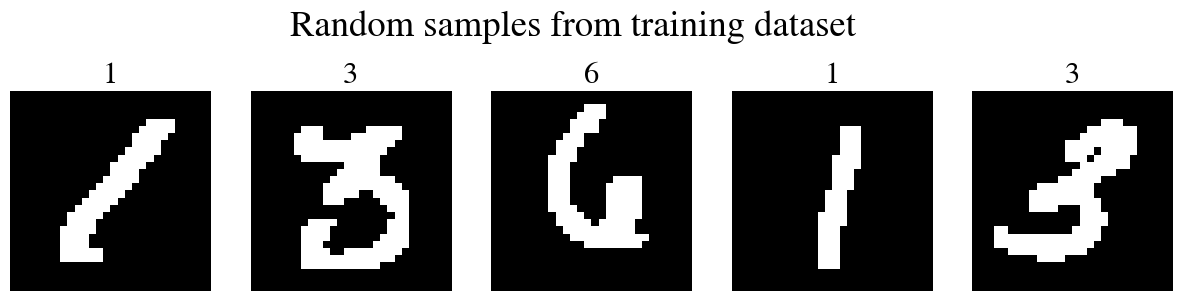

In [9]:
print(f"Number of data points in the training dataset: {len(train_loader)}")
print(f"Number of data points in the training dataset: {len(test_loader)}")
show_samples(train_loader, 5, "Random samples from training dataset")

## Model definition

### Intermediary model
We start by defining the convolutional model. For this project we use a simplified version of the [U-Net](http://arxiv.org/abs/1505.04597) architecture, with the following structure:

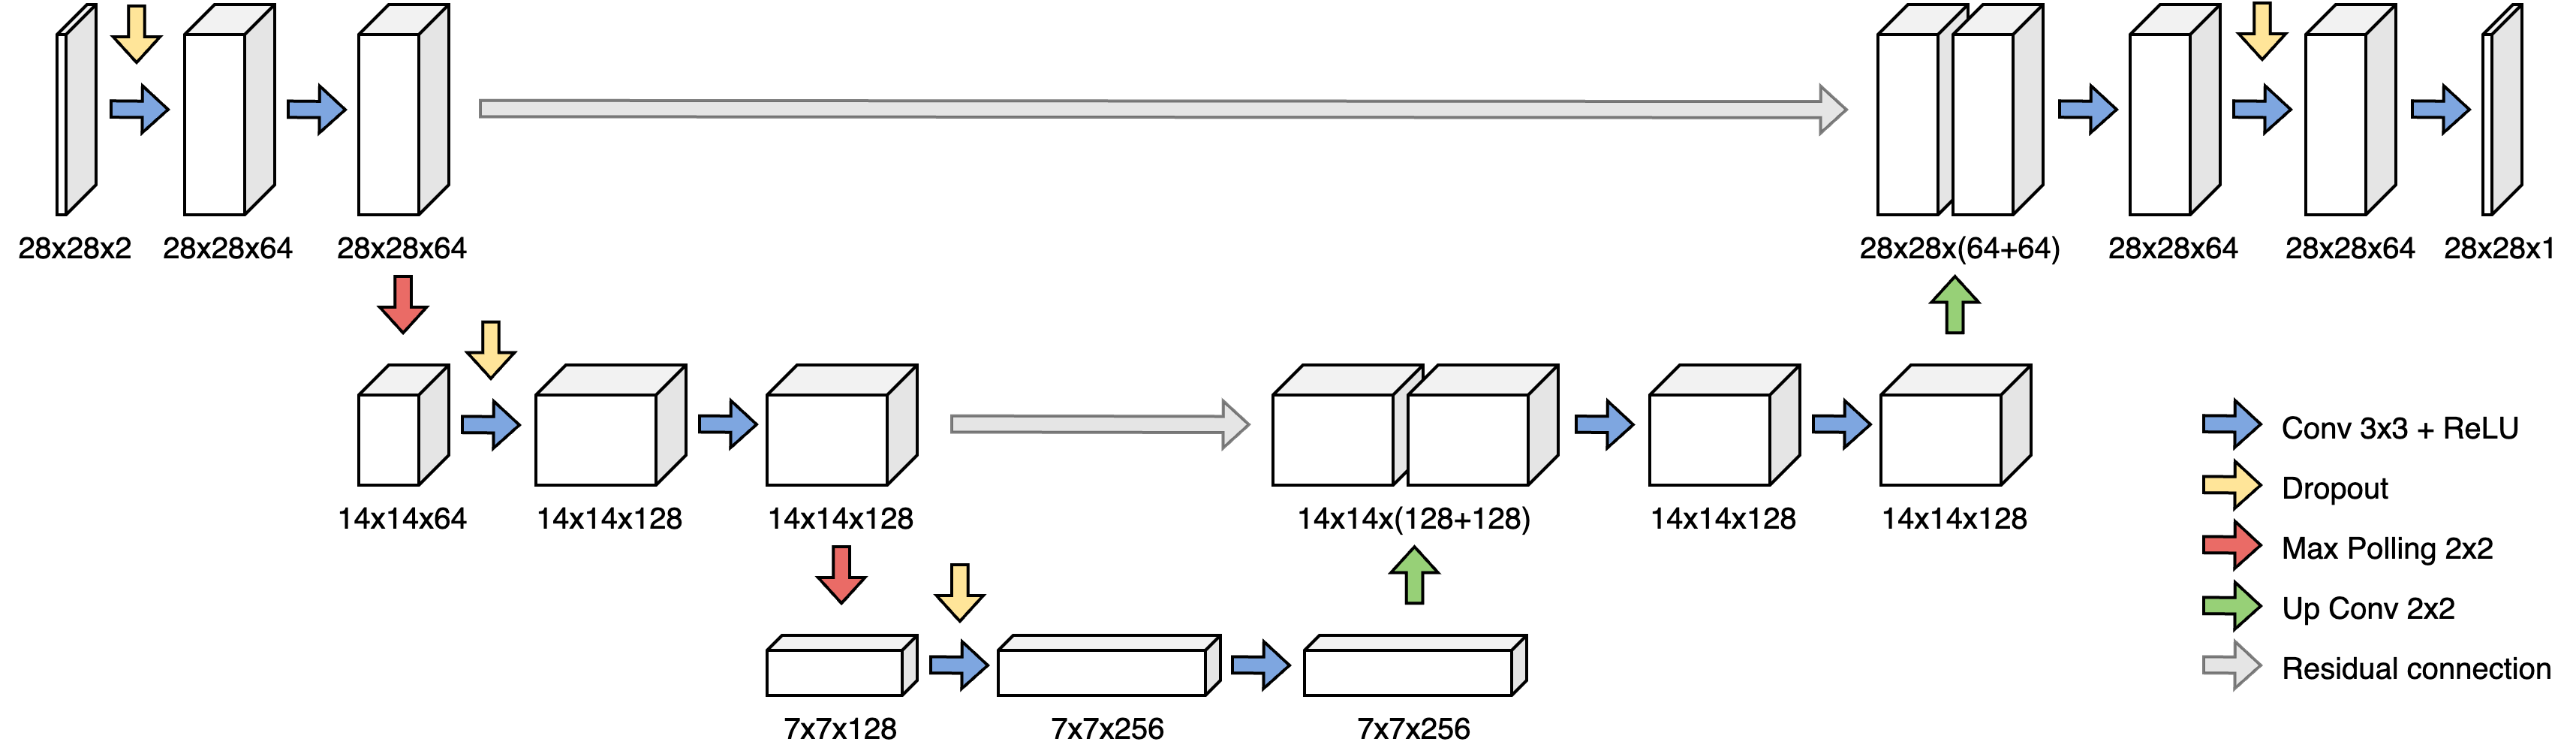

In [10]:
C = 128

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float=0.3):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Encoder
        # input: 28x28xIN
        self.e11 = nn.Conv2d(in_channels, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe11 = nn.Dropout(p=dropout)
        self.e12 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe12 = nn.Dropout(p=dropout)
        self.e13 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14x14xC//2

        # input: 14x14xC//2
        self.e21 = nn.Conv2d(C//2, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe21 = nn.Dropout(p=dropout)
        self.e22 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe22 = nn.Dropout(p=dropout)
        self.e23 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 28x28xC
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 7x7xC

        # input: 7x7xC
        self.e31 = nn.Conv2d(C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe31 = nn.Dropout(p=dropout)
        self.e32 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe32 = nn.Dropout(p=dropout)
        self.e33 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7xC

        # Decoder
        # input: 7x7x2*C
        self.upconv1 = nn.ConvTranspose2d(2*C, C, kernel_size=2, stride=2) # output: 14x14xC
        self.d11 = nn.Conv2d(2*C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd11 = nn.Dropout(p=dropout)
        self.d12 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd12 = nn.Dropout(p=dropout)
        self.d13 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC

        # input: 14x14x2*C
        self.upconv2 = nn.ConvTranspose2d(C, C//2, kernel_size=2, stride=2) # output: 28x28x7
        self.d21 = nn.Conv2d(C, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd21 = nn.Dropout(p=dropout)
        self.d22 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd22 = nn.Dropout(p=dropout)
        self.d23 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2

        # Output layer
        # input: 28x28xC//2
        self.outconv = nn.Conv2d(C//2, out_channels, kernel_size=1) # output: 28x28xOUT

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass on the model.

        Args:
            x (torch.Tensor): input data.

        Returns:
            torch.Tensor: output data.
        """
        # Encode the input data
        xe11 = self.dpe11(relu(self.e11(x)))
        xe12 = self.dpe12(relu(self.e12(xe11)))
        xe13 = relu(self.e13(xe12))
        xp1 = self.pool1(xe11)

        xe21 = self.dpe21(relu(self.e21(xp1)))
        xe22 = self.dpe22(relu(self.e22(xe21)))
        xe23 = relu(self.e23(xe22))
        xp2 = self.pool2(xe23)

        xe31 = self.dpe31(relu(self.e31(xp2)))
        xe32 = self.dpe32(relu(self.e32(xe31)))
        xe33 = relu(self.e33(xe32))

        # Decode the computed encoding
        xu11 = self.upconv1(xe33)
        xu12 = torch.cat([xu11, xe23], dim=1)
        xd11 = self.dpd11(relu(self.d11(xu12)))
        xd12 = self.dpd12(relu(self.d12(xd11)))
        xd13 = relu(self.d13(xd12))

        xu21 = self.upconv2(xd13)
        xu22 = torch.cat([xu21, xe13], dim=1)
        xd21 = self.dpd21(relu(self.d21(xu22)))
        xd22 = self.dpd22(relu(self.d22(xd21)))
        xd23 = relu(self.d23(xd22))

        # Output layer
        out = self.outconv(xd23)
        return out

## Bayesian Flow Network
Then we define the BFN model, adapted for 2D data.

### Model definition

In [11]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, network, D, K, beta=3.0):
        super(BayesianFlowNetwork2D, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K
        self.network = network

    def forward(self, theta: torch.Tensor, t: torch.Tensor, ema: torch_ema.ExponentialMovingAverage) -> torch.Tensor:
        """
        Performs a forward pass.

        Args:
            theta (torch.Tensor)
            t (torch.Tensor): time factor
            ema (torch_ema.ExponentialMovingAverage): EMA used in the model.

        Returns:
            torch.Tensor
        """
        theta = (theta * 2) - 1  # scaled in [-1, 1]
        theta = torch.transpose(theta, 1, 3)
        if ema is not None:
          with ema.average_parameters():
            output = self.network(theta + t[:, None, None, None])  # (B, D, D, K)
        else:
          output = self.network(theta + t[:, None, None, None])  # (B, D, D, K)
        return torch.transpose(output, 1, 3)

    def discrete_output_distribution(self, theta: torch.Tensor, t: torch.Tensor, ema: torch_ema.ExponentialMovingAverage=None) -> torch.Tensor:
        """
        Computes the discrete output distribution of the model.

        Args:
            theta (torch.Tensor)
            t (torch.Tensor): time factor
            ema (torch_ema.ExponentialMovingAverage, optional): EMA used in the model. Defaults to None.

        Returns:
            torch.Tensor
        """
        # Forward pass
        output = self.forward(theta, t, ema=ema)
        # Compute the output probabilities accordingly
        if self.K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x: torch.Tensor, time: float=None, training: bool=True) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Performs a step of the process.

        Args:
            x (torch.Tensor): input data.
            time (float, optional): time factor in the process. In [0, 1]. Defaults to None.
            training (bool, optional): weither it is during training phase or not. Defaults to True.

        Returns:
            torch.Tensor | tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: if training, only returns the current loss. Otherwise, returns the loss, the generated images, the categorical images and the time factor
        """
        # Step 1: Sample t from U(0, 1) if not provided
        t = torch.tensor(time, device=x.device, dtype=torch.float32)[None] if time else torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)
        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x.permute(0, 2, 3, 1).to(torch.int64), num_classes=self.K).float().squeeze()  # (B, D, D, K)
        mean = beta[:, None, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps
        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)
        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, D, K)
        e_x = one_hot_x
        e_hat = p_0  # (B, D, D, K)
        L_infinity = self.K * self.beta * t[:, None, None, None] * ((e_x - e_hat) ** 2)
        if training:
          return L_infinity.mean()
        else:
           k = torch.distributions.Categorical(probs=p_0).sample()
           return L_infinity.mean(), y, k, t

    @torch.inference_mode()
    def sample(self, batch_size: int=128, nb_steps: int=10, ema: torch_ema.ExponentialMovingAverage=None, device: str='cpu') -> torch.Tensor:
        self.eval()
        # get prior
        theta = torch.ones((batch_size, self.D, self.D, self.K), device=device) / self.K
        t = torch.zeros((theta.shape[0]), device=theta.device, dtype=theta.dtype)
        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)
            k_probs = self.discrete_output_distribution(theta, t, ema=ema)  # (B, D, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D, D)
            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)
            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)
            y = mean + std * eps  # (B, D, D, K)
            theta_prime = torch.exp(y) * theta
            theta = theta_prime / theta_prime.sum(-1, keepdim=True)
        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t), ema=ema)
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()
        return k_final

In [12]:
unet = UNet(2, 1, dropout=0.5)
bfn = BayesianFlowNetwork2D(network=unet, D=28, K=2).to(DEVICE)
ema = torch_ema.ExponentialMovingAverage(bfn.network.parameters(), decay=0.9999)
ema.to(DEVICE)



### Model training
The following cell exposes useful parameters for the training process. <br>
Here is a small breakdown of the role played by each of these parameters:
- `EPOCHS`: maximum number of epochs for the training process. Depending on the patience value, the training process might stop earlier.
- `EARLY_STOPPING`: weither to stop after a single epoch or not.
- `PATIENCE`: number of training steps after which the training process is stopped if the loss function has not been improved.
- `LEARNING_RATE`: learning rate used for optimizing the network.

If you want a quicker training process, choose lower values. If you need better results, choose higher parameters.

In [13]:
EPOCHS = 20
EARLY_STOPPING = False
PATIENCE = 1e6
LEARNING_RATE = 3e-4

We can then train the BFN on the data we previously prepared.

In [14]:
optim = AdamW(bfn.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), weight_decay=0.01)

In [15]:
def train_model(model: BayesianFlowNetwork2D, optimizer: torch.optim.Optimizer) -> list[float]:
  """
  Train a BFN model, given an optimizer.

  Args:
      model (BayesianFlowNetwork2D)
      optimizer (torch.optim.Optimizer)

  Returns:
      list[float]: training losses.
  """
  bfn_path = MODELS_PATH + "mnist_bfn.pt"
  if SAVE_MODEL:
    if os.path.exists(bfn_path):
      checkpoint = torch.load(bfn_path)
      model.load_state_dict(checkpoint['model_state_dict'])
      print(f"Trained model found, training process skipped. To train a new model, remove the file {bfn_path}.")
      return checkpoint["training_losses"]
  losses = []
  best_loss = inf
  k = 0
  stop = EARLY_STOPPING
  i = 0
  for i in range(EPOCHS):
    for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{EPOCHS}"):
        optimizer.zero_grad()
        loss = model.process(X.to(DEVICE))
        loss.backward()
        optimizer.step()
        ema.update()
        losses.append(loss.item())
        if loss.item() < best_loss:
          best_loss = loss.item()
          k = 0
        else:
          k += 1
          if k == PATIENCE:
            k = 0
            stop = True
            print("Patience value has been reached, ending training process.")
            break
    if SAVE_MODEL:
      torch.save({"model_state_dict": model.state_dict(), "training_losses": losses}, bfn_path)
      print(f"Trained model saved at {bfn_path}")
    if stop:
      break
  print(f"Model trained in {i+1} epochs.")
  if SAVE_MODEL:
    torch.save({"model_state_dict": model.state_dict(), "training_losses": losses}, bfn_path)
    print(f"Trained model saved at {bfn_path}")
  return losses

In [16]:
training_losses = train_model(bfn, optim)

Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [35:18<00:00, 17.95s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [34:01<00:00, 17.30s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [34:02<00:00, 17.31s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [34:01<00:00, 17.30s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:47<00:00, 17.18s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:49<00:00, 17.20s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:51<00:00, 17.21s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:45<00:00, 17.16s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:45<00:00, 17.16s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:49<00:00, 17.20s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:44<00:00, 17.16s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:40<00:00, 17.13s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:40<00:00, 17.12s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:42<00:00, 17.14s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:38<00:00, 17.11s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:38<00:00, 17.11s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 17/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:49<00:00, 17.20s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 18/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:31<00:00, 17.04s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 19/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:39<00:00, 17.12s/it]


Trained model saved at ./models/mnist_bfn.pt


Epoch 20/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [33:40<00:00, 17.12s/it]

Trained model saved at ./models/mnist_bfn.pt
Model trained in 20 epochs.
Trained model saved at ./models/mnist_bfn.pt


Once the model has been trained, we can visualize the loss function evolution during the training process.

In [33]:
checkpoint = torch.load('models/mnist_bfn.pt')
bfn.load_state_dict(checkpoint['model_state_dict'])
training_losses = checkpoint["training_losses"]
bfn.to(DEVICE)

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_23300\885193475.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/mnist_bfn.pt')


BayesianFlowNetwork2D(
  (network): UNet(
    (e11): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dpe11): Dropout(p=0.5, inplace=False)
    (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dpe12): Dropout(p=0.5, inplace=False)
    (e13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dpe21): Dropout(p=0.5, inplace=False)
    (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dpe22): Dropout(p=0.5, inplace=False)
    (e23): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dpe31): Dropout(p=0.5, inplace=False)
    (e32): Conv2d(256,

In [42]:
ema = torch_ema.ExponentialMovingAverage(bfn.network.parameters(), decay=0.9999)
ema.to(DEVICE)

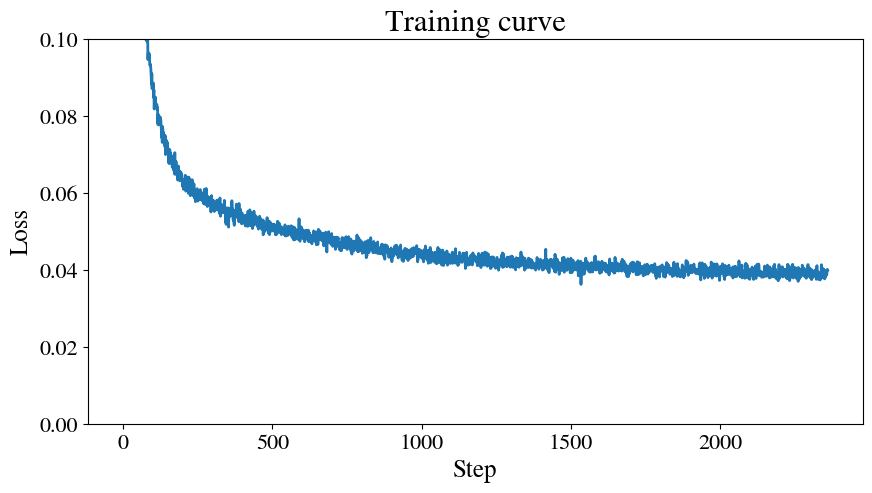

In [34]:
plt.plot(training_losses)
plt.title("Training curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.ylim(0, 0.1);

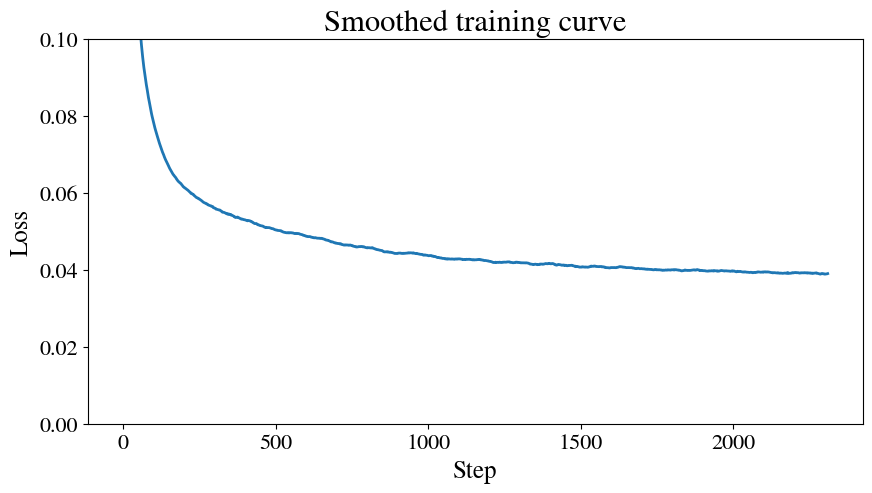

In [35]:
plt.plot(moving_average(training_losses, 50))
plt.title("Smoothed training curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.ylim(0, 0.1);

### Sample generation

Once the model has been trained, we can generate some new images.

In [45]:
x_hat = bfn.sample(device=DEVICE.type, nb_steps=1000, batch_size=9, ema=ema)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.88it/s]


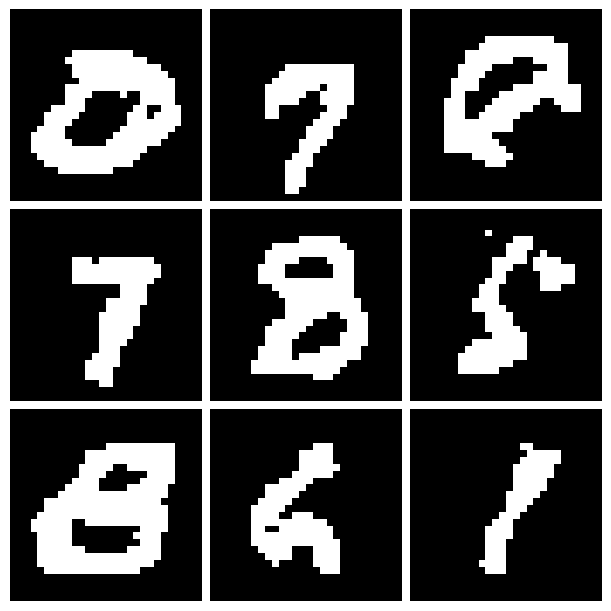

In [51]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6),  layout='constrained')
for i in range(9):
    ax[i // 3, i % 3].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
    ax[i // 3, i % 3].axis('off')
plt.savefig('bfn_samples.png')

We can also observe how the network processes images at different times during the sampling process in order to get an idea of how the images evolve during the generation.

In [40]:
x_0 = get_sample(train_loader)[0][0][0]

Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 10):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(DEVICE), training=False, time=t)
  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

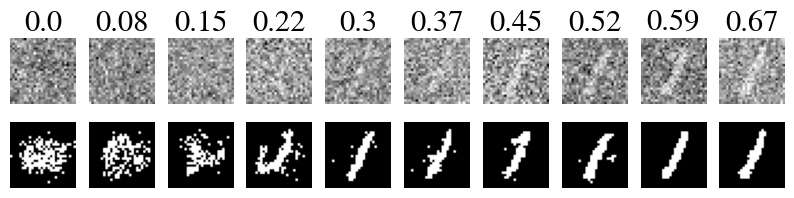

In [48]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2))

for i in range(10):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

plt.savefig('bfn_steps.png')

As the process evolves, the images are getting clearer and clearer, to finally look like a sample from the training dataset.